In [1]:
import sys
sys.path.append("../nptrack")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import trackpy as tp
from utility import *

%load_ext autoreload
%autoreload 2

firsty, we use a existing tracking code `trackpy` to perform the tracking procedure

In [2]:
D = 11

img = np.load('image.npy')
xyz = tp.locate(img, diameter=D)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()

then, we measure the shape of the particles from the tracked results

we have to assume the radius of the shape. Since the image is highly distorted along the z-axis, we will make the box quite big to enclose a entire particle

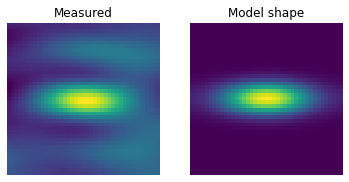

In [3]:
r_model = 20
model, measure = get_model(img, xyz, r_model, want_measure=True)

plt.subplot(121).imshow(measure.mean(0))
plt.title("Measured")
plt.axis('off')
plt.subplot(122).imshow(model.mean(0))
plt.title("Model shape")
plt.axis('off')
plt.show()

radii = ((np.array(model.shape) - 1) / 2).astype(int)
canvas_img, canvas = get_canvases(img, radii)

now we calculate the numerical derivative of the model w.r.t. to different axes.

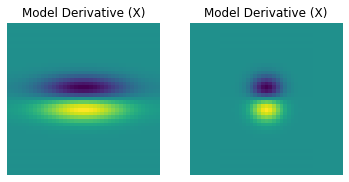

In [4]:
model_der = get_model_derivitives(model)

plt.subplot(121).imshow(model_der[0][:, model.shape[1]//2])
plt.title("Model Derivative (X)")
plt.xlabel("Z")
plt.xlabel("X")
plt.axis('off')
plt.subplot(122).imshow(model_der[0][:, :, model.shape[2]//2])
plt.title("Model Derivative (X)")
plt.xlabel("X")
plt.xlabel("Y")
plt.axis('off')
plt.show()

now we get the bounds for all the particle positions

In [5]:
bounds = get_position_bounds(xyz, img)

Now we have everything and we will refine our positions with the numerical optimiser

In [6]:
res = minimize(
    fun=r_cost,
    jac=r_jac,
    x0=xyz.ravel(),
    method='L-BFGS-B',
    args=(model, model_der, canvas_img, canvas, radii),
    bounds=bounds,
    tol=1,
    options={'maxiter': 100}
)

print(res.message, res.nfev)
opt = np.reshape(res.x, xyz.shape)
opt = remove_overlap(opt, img, D)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' 6


Now we will simulate a fake image, and try to find extra particle from the difference between the origional image and the fake image

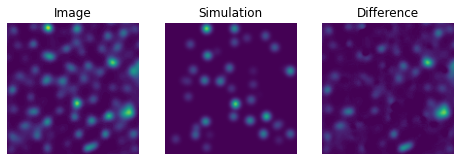

In [7]:
simulation = simulate(opt.astype(int), model, img)
diff = img - simulation
diff -= diff.min()

if 1:
    plt.subplot(131).imshow(img[:, :, 10], vmin=0, vmax=img.max())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(132).imshow(simulation[:, :, 10], vmin=0, vmax=img.max())
    plt.title('Simulation')
    plt.axis('off')
    plt.subplot(133).imshow((img - simulation)[:, :, 10], vmin=0, vmax=img.max())
    plt.title('Difference')
    plt.axis('off')
    plt.gcf().set_size_inches(8, 3)
    plt.show()

Now we track the particles in the difference map, and add them into our tracking result

The new tracking result is name `xyz_new`. We will remove the overlapped particles 

In [22]:
xyz_new = np.array(tp.locate(diff, D, preprocess=True))[:, :3]
dists = cdist(xyz_new, opt)
not_overlap = np.min(dists, axis=1) > D
opt = np.concatenate((opt, xyz_new[not_overlap]), axis=0)
print(opt.shape, xyz_tp.shape)

(296, 3) (201, 3)


Now we will refine the new positions

In [23]:
bounds = get_position_bounds(opt, img)

res = minimize(
    fun=r_cost,
    jac=r_jac,
    x0=opt.ravel(),
    method='L-BFGS-B',
    args=(model, model_der, canvas_img, canvas, radii),
    bounds=bounds,
    tol=1,
    options={'maxiter': 100}
)

print(res.message, res.nfev)
opt = np.reshape(res.x, opt.shape)
opt = remove_overlap(opt, img, D)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' 17


Let's check if there is more particles left in the difference map

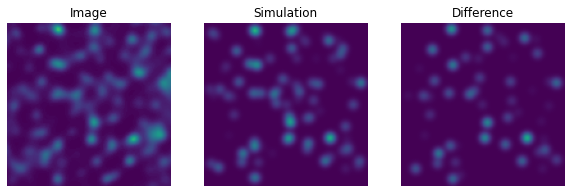

In [24]:
simulation = simulate(opt.astype(int), model, img)
simulation_tp = simulate(xyz_tp.astype(int), model, img)
diff = img - simulation
axis = 2
s = 15

if 1:
    box = [slice(0, img.shape[d]) for d in range(3)]
    box[axis] = s
    box = tuple(box)
    plt.subplot(131).imshow(img[box], vmin=0, vmax=img.max())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(132).imshow(simulation[box], vmin=0, vmax=img.max())
    plt.title('Simulation')
    plt.axis('off')
    plt.subplot(133).imshow(simulation_tp[box], vmin=0, vmax=img.max())
    plt.title('Difference')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 3)
    plt.show()

(296, 3) (201, 3)


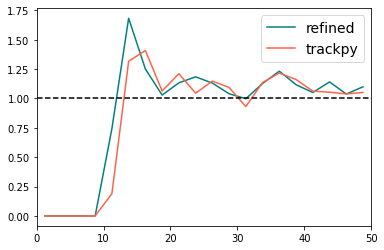

In [25]:
print(opt.shape, xyz_tp.shape)
gr_opt = get_gr(opt, 50, 21, 2e4)
gr_tp = get_gr(xyz_tp, 50, 21, 2e4)
plt.plot(*gr_opt, color='teal', label='refined')
plt.plot(*gr_tp, color='tomato', label='trackpy')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.legend(fontsize=14)
plt.show()